# Variational Autoencoder

## 参考

- https://github.com/pytorch/examples/blob/master/vae/main.py
- http://cympfh.cc/paper/VAE.html
- https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
- https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24
- log-likelihoodの最大化 = binary cross entropyの最小化？
- https://www.quora.com/What-are-the-differences-between-maximum-likelihood-and-cross-entropy-as-a-loss-function

## 原著論文

In [39]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [90]:
batch_size = 128
num_epochs = 100
seed = 1
out_dir = './vae_2'

In [91]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [41]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=False,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

In [42]:
print(len(train_loader))
print(len(test_loader))

469
79


In [43]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 12)
        self.fc41 = nn.Linear(12, 2)  # mu
        self.fc42 = nn.Linear(12, 2)  # logvar

        self.fc4 = nn.Linear(2, 12)
        self.fc5 = nn.Linear(12, 64)
        self.fc6 = nn.Linear(64, 128)
        self.fc7 = nn.Linear(128, 784)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        h = self.relu(self.fc1(x))
        h = self.relu(self.fc2(h))
        h = self.relu(self.fc3(h))
        return self.fc41(h), self.fc42(h)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = self.relu(self.fc4(z))
        h = self.relu(self.fc5(h))
        h = self.relu(self.fc6(h))
        return self.sigmoid(self.fc7(h))
    
    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

- `exp_()` でなくて `exp()` でも同じでは？
- eps（N(0,1) の乱数）がベクトルになっているため潜在変数の各次元ごとに異なる乱数をかけることになる
    - 数式見るとスカラーみたいだけどこの実装でよいのか？
    - `eps = Variable(std.data.new(1).normal_())` でも問題ないが比較してみる
- $logvar = \log \Sigma^2$
- $std = \exp ( 0.5 \log \Sigma^2) = \exp (\log \Sigma) = \Sigma$

In [44]:
model = VAE()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [45]:
data, _ = iter(train_loader).next()
outputs, mu, logvar = model(Variable(data))
print(outputs.size())
print(mu.size())
print(logvar.size())

torch.Size([128, 784])
torch.Size([128, 2])
torch.Size([128, 2])


In [46]:
def loss_function(recon_x, x, mu, logvar):
    # size_average=Falseなのでバッチ内のサンプルの合計lossを求める
    # reconstruction loss 入力画像をどのくらい正確に復元できたか？
    # 数式では対数尤度の最大化だが交差エントロピーlossの最小化と等価
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)

    # 潜在空間zに対する正則化項
    # P(z|x) が N(0, I)に近くなる（KL-distanceが小さくなる）ようにする
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [47]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if cuda:
            data = Variable(data.cuda())
        else:
            data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
    
    # loss_function() は平均ではなく全サンプルの合計lossを返すのでサンプル数で割る
    train_loss /= len(train_loader.dataset)

    return train_loss    
    

def test(epoch):
    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        if cuda:
            data = Variable(data.cuda(), volatile=True)
        else:
            data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.data[0]
        
        if epoch % 10 == 0:
            # 10エポックごとに最初のminibatchの入力画像と復元画像を保存
            if batch_idx == 0:
                n = 8
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.data.cpu(),
                           '{}/reconstruction_{}.png'.format(out_dir, epoch), nrow=n)

    test_loss /= len(test_loader.dataset)

    return test_loss

- VAEは教師なし学習なのでラベルは使わない

In [ ]:
loss_list = []
test_loss_list = []
for epoch in range(1, num_epochs + 1):
    loss = train(epoch)
    test_loss = test(epoch)

    print('epoch [{}/{}], loss: {:.4f} test_loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss,
        test_loss))

    # logging
    loss_list.append(loss)
    test_loss_list.append(test_loss)

In [ ]:
# save the training model
np.save('loss_list.npy', np.array(loss_list))
np.save('test_loss_list.npy', np.array(test_loss_list))
torch.save(model.state_dict(), 'vae.pth')

## 結果の分析

In [35]:
!gdrive download 1fUBgun1jxeV7SRguRi3KYdQaKLnL-1xN --recursive

### 学習曲線

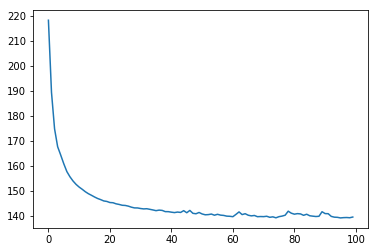

In [92]:
loss_list = np.load('{}/loss_list.npy'.format(out_dir))
plt.plot(loss_list)

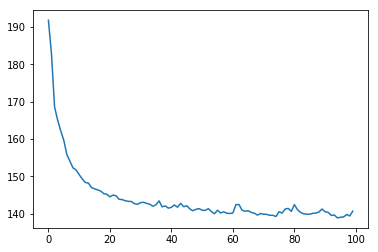

In [93]:
test_loss_list = np.load('{}/test_loss_list.npy'.format(out_dir))
plt.plot(test_loss_list)

### 入力画像と再構成画像の比較

In [83]:
from IPython.display import Image

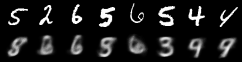

In [85]:
Image('vae_2/reconstruction_10.png')

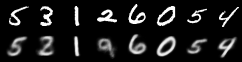

In [86]:
Image('vae_2/reconstruction_100.png')

### 潜在空間の可視化

In [52]:
model.load_state_dict(torch.load('{}/vae.pth'.format(out_dir),
                                 map_location=lambda storage,
                                 loc: storage))
test_dataset = datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
images, labels = iter(test_loader).next()
images = images.view(10000, -1)

In [53]:
print(images.size())

torch.Size([10000, 784])


In [67]:
# 784次元ベクトルを2次元ベクトルにencode
z = model.encode(Variable(images, volatile=True))
mu, logvar = z
mu, logvar = mu.data.numpy(), logvar.data.numpy()
print(mu.shape, logvar.shape)

(10000, 2) (10000, 2)


In [68]:
mu[:10]

array([[ 1.1293622 , -1.6679958 ],
       [-0.5758019 , -0.30339047],
       [ 1.7566175 ,  1.7714332 ],
       [-1.5143422 ,  0.69150454],
       [-0.20344958, -1.3952695 ],
       [ 1.471147  ,  1.5814201 ],
       [ 1.1976703 , -0.66248226],
       [-0.3685735 , -0.85618556],
       [ 0.24440981, -0.2869767 ],
       [ 0.42248768, -0.9765328 ]], dtype=float32)

In [72]:
logvar[:10]

array([[-7.038686 , -5.613024 ],
       [-8.011477 , -7.3098183],
       [-5.1206408, -5.3586197],
       [-6.601241 , -6.810195 ],
       [-7.055626 , -5.633131 ],
       [-5.6671486, -5.7274218],
       [-6.3903236, -6.445199 ],
       [-7.719372 , -6.862115 ],
       [-8.8653   , -7.367834 ],
       [-8.429835 , -6.9790907]], dtype=float32)

In [73]:
std = np.exp(0.5 * logvar)
std[:10]

array([[0.02961889, 0.06041535],
       [0.01821083, 0.02586385],
       [0.07727998, 0.06861049],
       [0.03686029, 0.03320358],
       [0.02936908, 0.05981101],
       [0.0588023 , 0.05705664],
       [0.0409599 , 0.03985133],
       [0.02107462, 0.03235271],
       [0.01188296, 0.02512437],
       [0.01477354, 0.03051474]], dtype=float32)

In [69]:
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

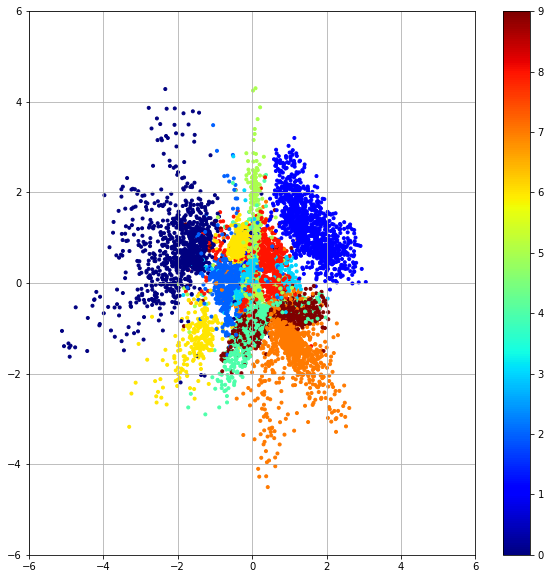

In [76]:
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.xlim((-6, 6))
plt.ylim((-6, 6))
plt.grid()

## 画像の再現度が低いので潜在空間を20次元に

In [84]:
out_dir = './vae_20'

In [77]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)  # mu
        self.fc22 = nn.Linear(400, 20)  # logvar
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [81]:
!gdrive download 1eri3iEvGbXMkqp4H8G6zjj9vyNh1otTf --recursive

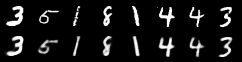

In [87]:
Image('vae_20/reconstruction_10.png')

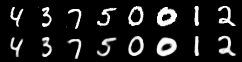

In [88]:
Image('vae_20/reconstruction_100.png')